In [1]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib

In [2]:
local_zip = '/content/drive/MyDrive/Animal-10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
os.listdir()

['.config', 'raw-img', 'drive', 'translate.py', 'sample_data']

In [4]:
dir_path = '/content/raw-img'
os.listdir(dir_path)

['farfalla',
 'elefante',
 'gatto',
 'pecora',
 'scoiattolo',
 'ragno',
 'mucca',
 'cavallo',
 'gallina',
 'cane']

In [5]:
train_generator= tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    validation_split=0.2,
    image_size=(224,224),
    seed=100,
    batch_size=32,
    subset="training",
)
val_generator= tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    validation_split=0.2,
    image_size=(224,224),
    seed=200,
    batch_size=32,
    subset="validation",
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size = 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size = 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(256, kernel_size = 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

optimizer = tf.optimizers.Adam(learning_rate=1e-3, amsgrad=True, use_ema=True)
model.compile(loss='sparse_categorical_crossentropy',
		optimizer=optimizer,
		metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                        

In [7]:
class ModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93:
            self.model.stop_training = True

In [8]:
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    verbose=2,
    callbacks=ModelCallback())

Epoch 1/200
655/655 - 74s - loss: 2.3491 - accuracy: 0.3989 - val_loss: 1.9440 - val_accuracy: 0.4619 - 74s/epoch - 114ms/step
Epoch 2/200
655/655 - 61s - loss: 1.7622 - accuracy: 0.5289 - val_loss: 1.5068 - val_accuracy: 0.5457 - 61s/epoch - 93ms/step
Epoch 3/200
655/655 - 61s - loss: 1.3911 - accuracy: 0.6002 - val_loss: 1.2606 - val_accuracy: 0.5849 - 61s/epoch - 93ms/step
Epoch 4/200
655/655 - 62s - loss: 1.1480 - accuracy: 0.6471 - val_loss: 0.9803 - val_accuracy: 0.6819 - 62s/epoch - 94ms/step
Epoch 5/200
655/655 - 62s - loss: 0.9696 - accuracy: 0.6923 - val_loss: 0.8754 - val_accuracy: 0.7075 - 62s/epoch - 94ms/step
Epoch 6/200
655/655 - 61s - loss: 0.8305 - accuracy: 0.7261 - val_loss: 0.7976 - val_accuracy: 0.7303 - 61s/epoch - 93ms/step
Epoch 7/200
655/655 - 61s - loss: 0.7359 - accuracy: 0.7517 - val_loss: 0.6925 - val_accuracy: 0.7626 - 61s/epoch - 93ms/step
Epoch 8/200
655/655 - 61s - loss: 0.6608 - accuracy: 0.7786 - val_loss: 0.6564 - val_accuracy: 0.7721 - 61s/epoch - 9

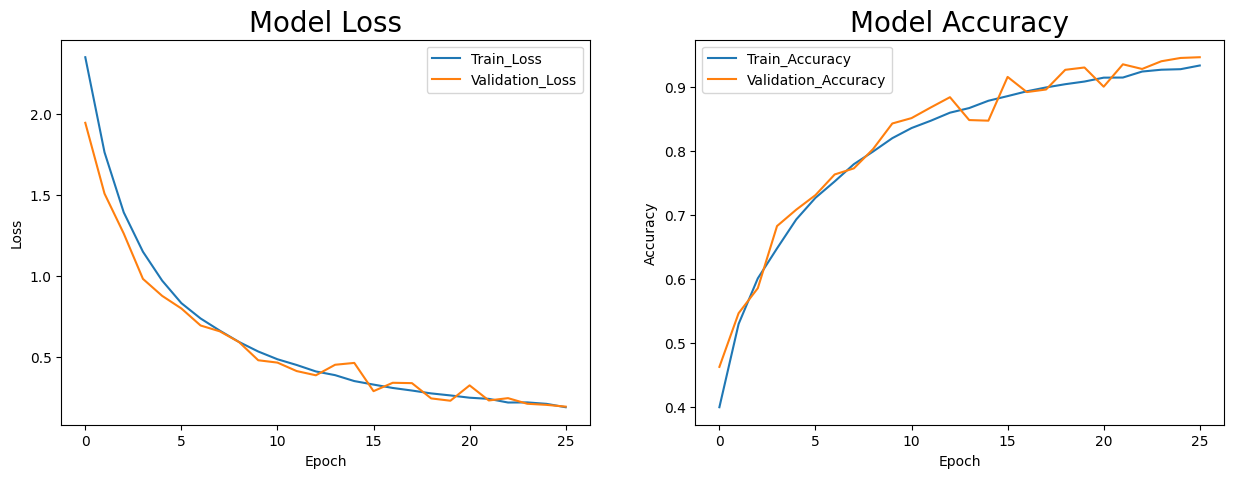

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train_Loss')
plt.plot(history.history['val_loss'],label='Validation_Loss')
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Train_Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation_Accuracy')
plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [10]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

3431764

In [11]:
os.listdir()

['.config',
 'vegs.tflite',
 'raw-img',
 'saved_model',
 'drive',
 'translate.py',
 'sample_data']